Indicaciones:

Implementar la expresión matemática dada en Python utilizando la biblioteca micrograd, asegurando que los valores sean correctamente almacenados como nodos computacionales y que el cálculo de gradientes se realice de manera automática mediante backpropagation.

Expresión Matemática a Implementar:
𝐿 = ((𝑎 × 𝑏 + 𝑐)2 + 𝑑 + 𝑒 × 𝑓) × 𝑔

Donde:
• a, b, c, d, e, f, g son valores de entrada
• Se debe realizar el cálculo del gradiente de L con respecto a todas las variables mediante
backpropagation.
• Los valores son:
a = 2
b = 3
c = 1
d = 1
e = 4
f = 2
g = 5

In [205]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [206]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    #return f"Value(data={self.data})"
    return f"Value(data={self.data} - grad={self.grad} - {self.label})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


In [207]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [208]:
a = Value(2.0, label='a')
print(a)
b = Value(3.0, label='b')
print(b)

h = a * b; h.label='h'
print(h)

c = Value(1.0, label='c')
print(c)

i = h + c; i.label='i'
print(i)

j = i**2; j.label='j'
print(j)

d = Value(1.0, label='d')
print(d)

n = j + d; n.label='n'
print(n)

e = Value(4.0, label='e')
print(e)
f = Value(2.0, label='f')
print(f)

k = e * f; k.label='k'
print(k)

m = n + k; m.label='m'
print(m)

g = Value(5.0, label='g')
print(g)
#L = (((a * b) + c)**2 + d + e * f) * g; L.label = 'L'
L = m * g; L.label = 'L'


print(L)

Value(data=2.0 - grad=0.0 - a)
Value(data=3.0 - grad=0.0 - b)
Value(data=6.0 - grad=0.0 - h)
Value(data=1.0 - grad=0.0 - c)
Value(data=7.0 - grad=0.0 - i)
Value(data=49.0 - grad=0.0 - j)
Value(data=1.0 - grad=0.0 - d)
Value(data=50.0 - grad=0.0 - n)
Value(data=4.0 - grad=0.0 - e)
Value(data=2.0 - grad=0.0 - f)
Value(data=8.0 - grad=0.0 - k)
Value(data=58.0 - grad=0.0 - m)
Value(data=5.0 - grad=0.0 - g)
Value(data=290.0 - grad=0.0 - L)


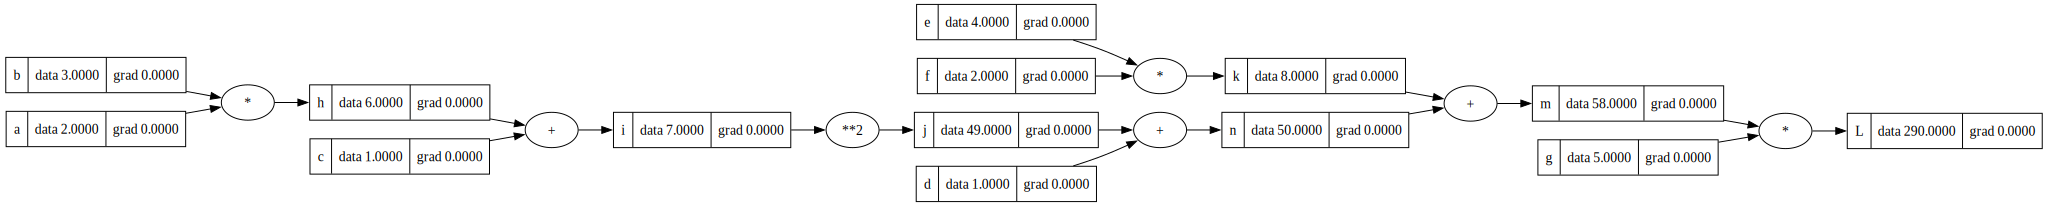

In [209]:
draw_dot(L)

In [210]:
def lol():
  # (f(x+h)-f(x))/h
  delta = 0.001
  
  #L = (((a * b) + c)**2 + d + e * f) * g; L.label = 'L'
  a = Value(2.0, label='a')
  b = Value(3.0, label='b')
  h = a * b; h.label='h'
  c = Value(1.0, label='c')
  i = h + c; i.label='i'
  j = i**2; j.label='j'
  d = Value(1.0, label='d')
  n = j + d; n.label='n'
  e = Value(4.0, label='e')
  f = Value(2.0, label='f')
  k = e * f; k.label='k'
  m = n + k; m.label='m'
  g = Value(5.0, label='g')
  L = m * g; L.label = 'L'
  
  L1 = L.data
  
  vars = ['a','b','h','c','i','j','d','n','e','f','k','m','g','L']
  grads = []
  
  for item in vars:
    a = Value(2.0, label='a')
    a.data+=delta if item == 'a' else 0
    b = Value(3.0, label='b')
    b.data+=delta if item == 'b' else 0
    h = a * b; h.label='h'
    h.data+=delta if item == 'h' else 0
    c = Value(1.0, label='c')
    c.data+=delta if item == 'c' else 0
    i = h + c; i.label='i'
    i.data+=delta if item == 'i' else 0
    j = i**2; j.label='j'
    j.data+=delta if item == 'j' else 0
    d = Value(1.0, label='d')
    d.data+=delta if item == 'd' else 0
    n = j + d; n.label='n'
    n.data+=delta if item == 'n' else 0
    e = Value(4.0, label='e')
    e.data+=delta if item == 'e' else 0
    f = Value(2.0, label='f')
    f.data+=delta if item == 'f' else 0
    k = e * f; k.label='k'
    k.data+=delta if item == 'k' else 0
    m = n + k; m.label='m'
    m.data+=delta if item == 'm' else 0
    g = Value(5.0, label='g')
    g.data+=delta if item == 'g' else 0
    L = m * g; L.label = 'L'
    L.data+=delta if item == 'L' else 0

    L2 = L.data
    
    if item == 'a':
      a.grad=round((L2 - L1)/delta, 1)
      grads.append({item: a.grad})
    if item == 'b':
      b.grad=round((L2 - L1)/delta, 1)
      grads.append({item: b.grad})
    if item == 'h':
      h.grad=round((L2 - L1)/delta, 1)
      grads.append({item: h.grad})
    if item == 'c':
      c.grad=round((L2 - L1)/delta, 1)
      grads.append({item: c.grad})
    if item == 'i':
      i.grad=round((L2 - L1)/delta, 1)
      grads.append({item: i.grad})
    if item == 'j':
      j.grad=round((L2 - L1)/delta, 1)
      grads.append({item: j.grad})
    if item == 'd':
      d.grad=round((L2 - L1)/delta, 1)
      grads.append({item: d.grad})
    if item == 'n':
      n.grad=round((L2 - L1)/delta, 1)
      grads.append({item: n.grad})
    if item == 'e':
      e.grad=round((L2 - L1)/delta, 1)
      grads.append({item: e.grad})
    if item == 'f':
      f.grad=round((L2 - L1)/delta, 1)
      grads.append({item: f.grad})
    if item == 'k':
      k.grad=round((L2 - L1)/delta, 1)
      grads.append({item: k.grad})
    if item == 'm':
      m.grad=round((L2 - L1)/delta, 1)
      grads.append({item: m.grad})
    if item == 'g':
      g.grad=round((L2 - L1)/delta, 1)
      grads.append({item: g.grad})
    if item == 'L':
      L.grad=round((L2 - L1)/delta, 1)
      grads.append({item: L.grad})
      
  return grads

grads = lol()


In [211]:
print(grads)

[{'a': 210.0}, {'b': 140.0}, {'h': 70.0}, {'c': 70.0}, {'i': 70.0}, {'j': 5.0}, {'d': 5.0}, {'n': 5.0}, {'e': 10.0}, {'f': 20.0}, {'k': 5.0}, {'m': 5.0}, {'g': 58.0}, {'L': 1.0}]


In [217]:
for result in (f"dL/d{key}={value}" for grad in grads for key, value in grad.items()):
    print(result)

dL/da=210.0
dL/db=140.0
dL/dh=70.0
dL/dc=70.0
dL/di=70.0
dL/dj=5.0
dL/dd=5.0
dL/dn=5.0
dL/de=10.0
dL/df=20.0
dL/dk=5.0
dL/dm=5.0
dL/dg=58.0
dL/dL=1.0


In [202]:
for variable in [a, b, h, c, i, j, d, n, e, f, k, m, g, L]:
    result = next((item for item in grads if variable.label in item), None)
    variable.grad = result[variable.label]

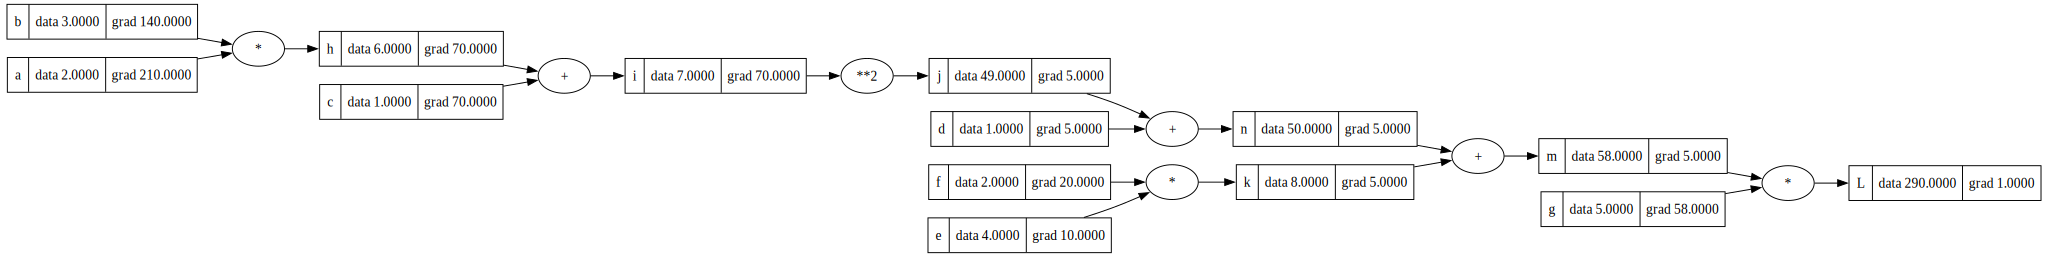

In [203]:
draw_dot(L)

In [218]:
L.backward()

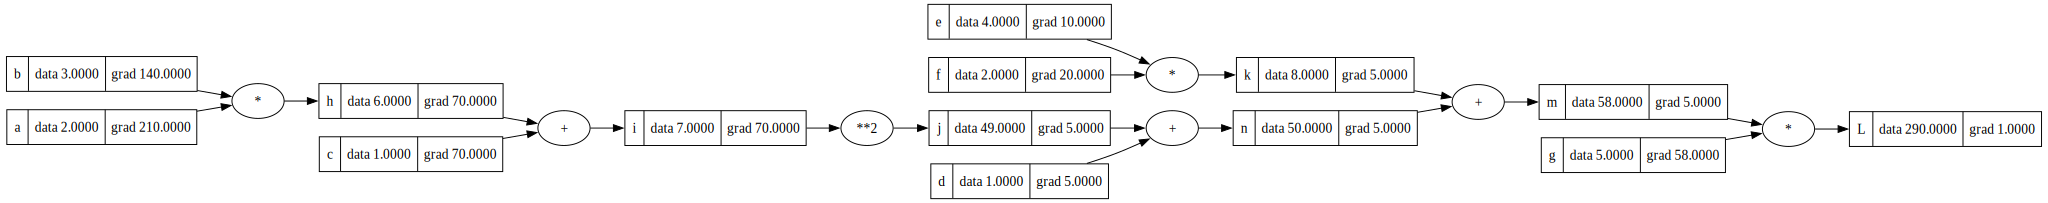

In [219]:
draw_dot(L)